In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.svm import SVC
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import pandas as pd


def load_data_to_df():
    file_path_data = "CATSnDOGS.csv"
    file_path_labels = "Labels.csv"
    delimiter = ","
    df_data = pd.read_csv(file_path_data, delimiter=delimiter, header=0, quotechar='"')
    df_labels = pd.read_csv(
        file_path_labels, delimiter=delimiter, header=0, quotechar='"'
    )
    images = df_data.to_numpy()
    correct_images = [im.reshape(64, 64).T for im in images]
    correct_images = np.array(correct_images)
    flattened_correct_images = [im.flatten() for im in correct_images]
    df = pd.DataFrame(flattened_correct_images)
    df["Label"] = df_labels
    
    return df


def load_unified_data():
    file_path_data = "CATSnDOGS.csv"
    file_path_labels = "Labels.csv"
    delimiter = ","
    df_data = pd.read_csv(file_path_data, delimiter=delimiter, header=0, quotechar='"')
    df_labels = pd.read_csv(
        file_path_labels, delimiter=delimiter, header=0, quotechar='"'
    )
    df = pd.concat([df_data, df_labels], axis=1)
    df.rename(columns={"x": "Label"}, inplace=True)
    return df


def plot_image_on_ax(ax, image, pixel_size=64, index=""):
    ax.imshow(
        image.reshape(pixel_size, pixel_size),
        cmap="gray",
    )
    ax.set_title(f"{index}", fontsize=30)  # Increase the font size to 16
    ax.axis("off")


def get_image_from_df(df, index):
    return df.iloc[index, :-1].values


def get_all_images_from_df_as_numpy(df):
    # Note: this does not work for the df with blocks
    return df.iloc[:, :-1].to_numpy()


def reshape_into_blocks(images):
    # Reshape each 64x64 image into 16 blocks of 16x16
    # Assuming images.shape == (n_samples, 64, 64)
    n_samples = images.shape[0]
    blocks = images.reshape(n_samples, 4, 16, 4, 16)
    blocks = blocks.swapaxes(2, 3).reshape(n_samples, 16, 256)
    return blocks


def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
    if colors is None:
        colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    n_bars = len(data)
    bar_width = total_width / n_bars
    bars = []

    for i, (name, values) in enumerate(data.items()):
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2
        for x, y in enumerate(values):
            bar = ax.bar(
                x + x_offset,
                y,
                width=bar_width * single_width,
                color=colors[i % len(colors)],
            )
        bars.append(bar[0])

    if legend:
        ax.legend(bars, data.keys(), loc="lower center")

In [3]:
df = load_data_to_df()

In [4]:
# Count the number of dogs and cats
dogs = df[df["Label"] == 1]
n_dogs = dogs.shape[0]
print(f"Number of dogs: {n_dogs}")


cats = df[df["Label"] == 0]
n_cats = cats.shape[0]
print(f"Number of cats: {n_cats}")

Number of dogs: 101
Number of cats: 97


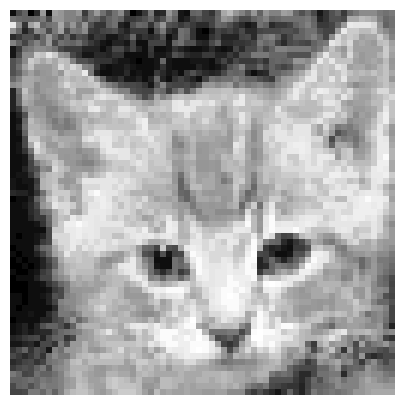

In [5]:
# Plot the first image
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_image_on_ax(ax, get_image_from_df(df, 0))
plt.show()

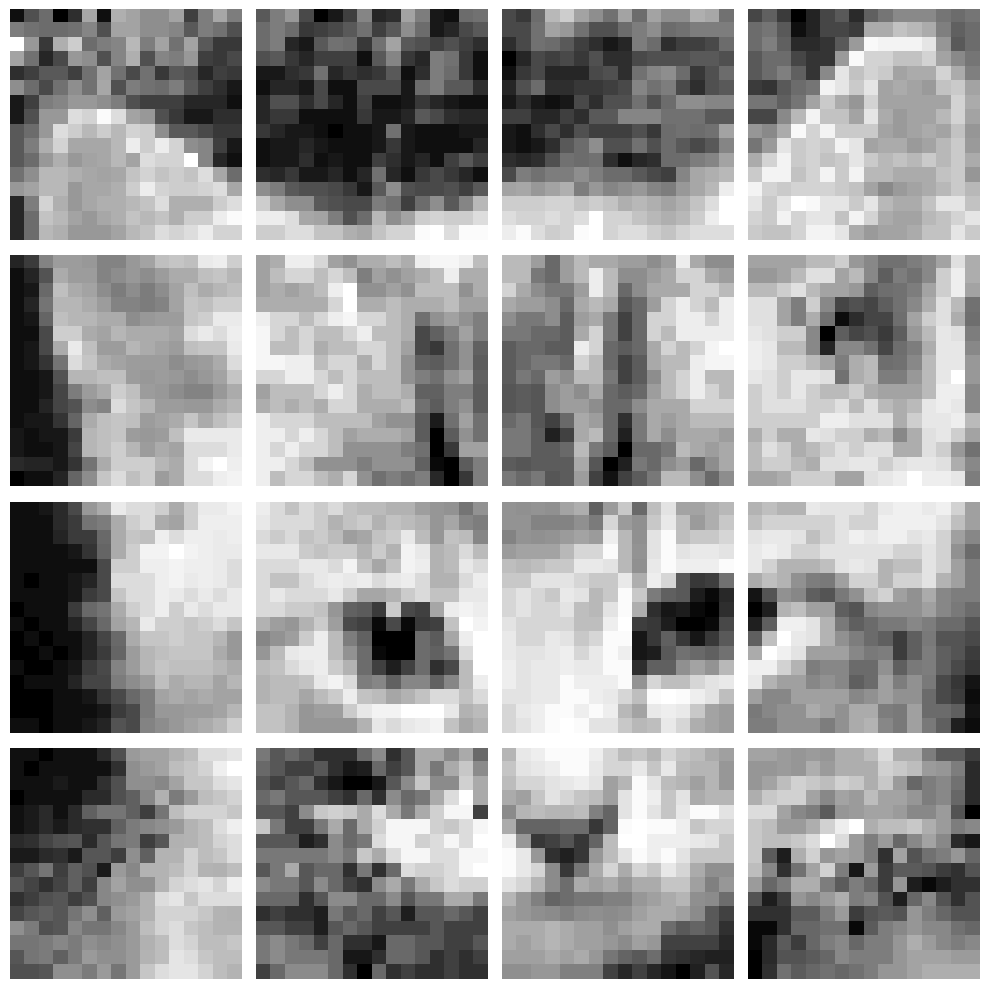

In [6]:
images = get_all_images_from_df_as_numpy(df)
block_images = reshape_into_blocks(images)
first_block_image = block_images[0]

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    plot_image_on_ax(ax, first_block_image[i], pixel_size=16)

plt.tight_layout()
plt.show()

In [7]:
block_images.shape
print(f"Block images shape: {block_images.shape}")

Block images shape: (198, 16, 256)


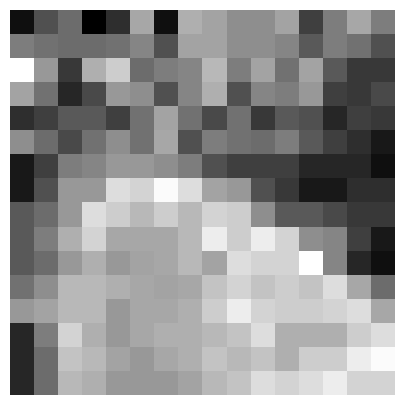

In [8]:
# Plot the first block
first_block = block_images[0][0][:]
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_image_on_ax(ax, first_block, pixel_size=16)
plt.show()

In [9]:
# Expand the labels to fit the number of blocks
labels = df["Label"].values
labels = np.repeat(labels, 16)
labels.shape
print(f"Labels shape: {labels.shape}")

Labels shape: (3168,)


In [10]:
blocks = block_images.reshape(-1, 256)   
blocks.shape
print(f"Blocks shape: {blocks.shape}")

Blocks shape: (3168, 256)


In [11]:
# Create a new DataFrame with the blocks and labels
df_blocks = pd.DataFrame(blocks)
df_blocks["Label"] = labels
df_blocks.head(5)

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,Label
0,23,78,102,10,49,152,23,159,149,131,...,149,166,176,198,190,198,211,190,190,0
1,86,116,139,73,10,31,64,123,43,49,...,152,176,190,190,223,227,198,223,223,0
2,73,59,102,166,184,149,131,107,149,102,...,190,198,198,184,176,190,198,198,198,0
3,86,107,78,31,59,86,102,64,107,123,...,166,152,159,159,166,184,184,211,190,0
4,43,64,131,152,152,149,131,131,149,159,...,211,184,198,152,166,211,211,227,232,0


In [12]:
# Print the number of cats and dogs in the dataset
n_cats = df_blocks[df_blocks["Label"] == 0].shape[0]
n_dogs = df_blocks[df_blocks["Label"] == 1].shape[0]
print(f"Number of cat blocks: {n_cats}")
print(f"Number of dog blocks: {n_dogs}")

Number of cat blocks: 1552
Number of dog blocks: 1616


In [13]:
# Add a column to the dataframe that contains the block index
df_blocks["Block"] = df_blocks.index % 16
df_blocks.head(5)

,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,Label,Block
0,23,78,102,10,49,152,23,159,149,131,...,166,176,198,190,198,211,190,190,0,0
1,86,116,139,73,10,31,64,123,43,49,...,176,190,190,223,227,198,223,223,0,1
2,73,59,102,166,184,149,131,107,149,102,...,198,198,184,176,190,198,198,198,0,2
3,86,107,78,31,59,86,102,64,107,123,...,152,159,159,166,184,184,211,190,0,3
4,43,64,131,152,152,149,131,131,149,159,...,184,198,152,166,211,211,227,232,0,4


In [14]:
classifiers = {
    "kNN": KNeighborsClassifier(n_neighbors=11),
    "Logistic Regression": LogisticRegression(max_iter=1000),  # Increase max_iter
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Neural Network": MLPClassifier(max_iter=1000)  # Increase max_iter
}

## One-Shot Classification Performance Evaluation

In [15]:
selected_blocks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

cv_block_accuracy_per_classifier = {
    "kNN": [],
    "Logistic Regression": [],
    "SVM": [],
    "Random Forest": [],
    "Neural Network": [],
}

for block in selected_blocks:
    block_data = df_blocks[df_blocks["Block"] == block]

    X = block_data.iloc[:, :-2].values
    y = block_data["Label"].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train a classifier
    for clf_string, clf in classifiers.items():
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)

        acc = accuracy_score(y_test, y_pred)

        cv_block_accuracy_per_classifier[clf_string].append(acc)

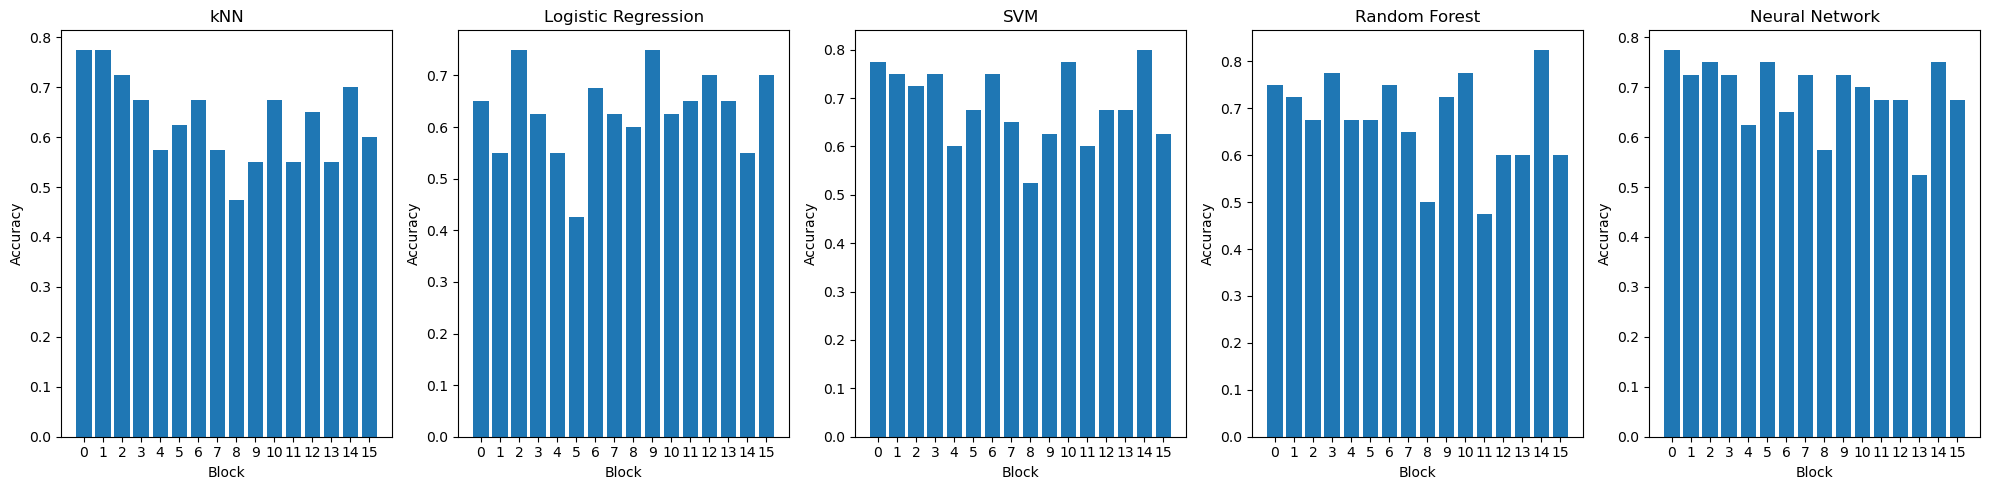

In [16]:
# For each classifier plot the accuracy for each block using a barplot
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
axes = axes.ravel()

for i, (clf, accs) in enumerate(cv_block_accuracy_per_classifier.items()):
    ax = axes[i]
    ax.bar(selected_blocks, accs)
    ax.set_title(clf)
    ax.set_xlabel("Block")
    ax.set_ylabel("Accuracy")
    ax.xaxis.set_ticks(selected_blocks)

plt.tight_layout()
plt.show()

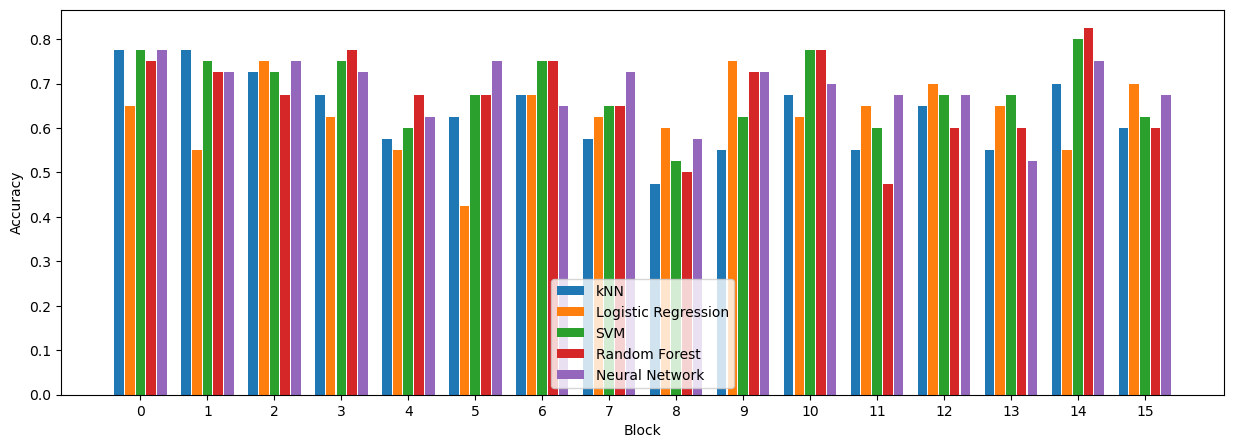

In [17]:
cv_data = {
    "kNN": cv_block_accuracy_per_classifier["kNN"],
    "Logistic Regression": cv_block_accuracy_per_classifier["Logistic Regression"],
    "SVM": cv_block_accuracy_per_classifier["SVM"],
    "Random Forest": cv_block_accuracy_per_classifier["Random Forest"],
    "Neural Network": cv_block_accuracy_per_classifier["Neural Network"],
}

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
bar_plot(ax, cv_data, total_width=0.8, single_width=0.9)
ax.set_xlabel("Block")
ax.set_ylabel("Accuracy")
ax.xaxis.set_ticks(selected_blocks)
plt.show()

## Cross-validation

In [18]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline

selected_blocks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

cv_block_accuracy_per_classifier = {
    "kNN": [],
    "Logistic Regression": [],
    "SVM": [],
    "Random Forest": [],
    "Neural Network": [],
}

for block in selected_blocks:
    block_data = df_blocks[df_blocks["Block"] == block]

    X = block_data.iloc[:, :-2].values
    y = block_data["Label"].values

    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    for clf_string, clf in classifiers.items():
        pipeline = Pipeline([("scaler", StandardScaler()), ("clf", clf)])
        scores = cross_val_score(pipeline, X, y, cv=cv, scoring="accuracy")
        cv_block_accuracy_per_classifier[clf_string].append(scores.mean())    

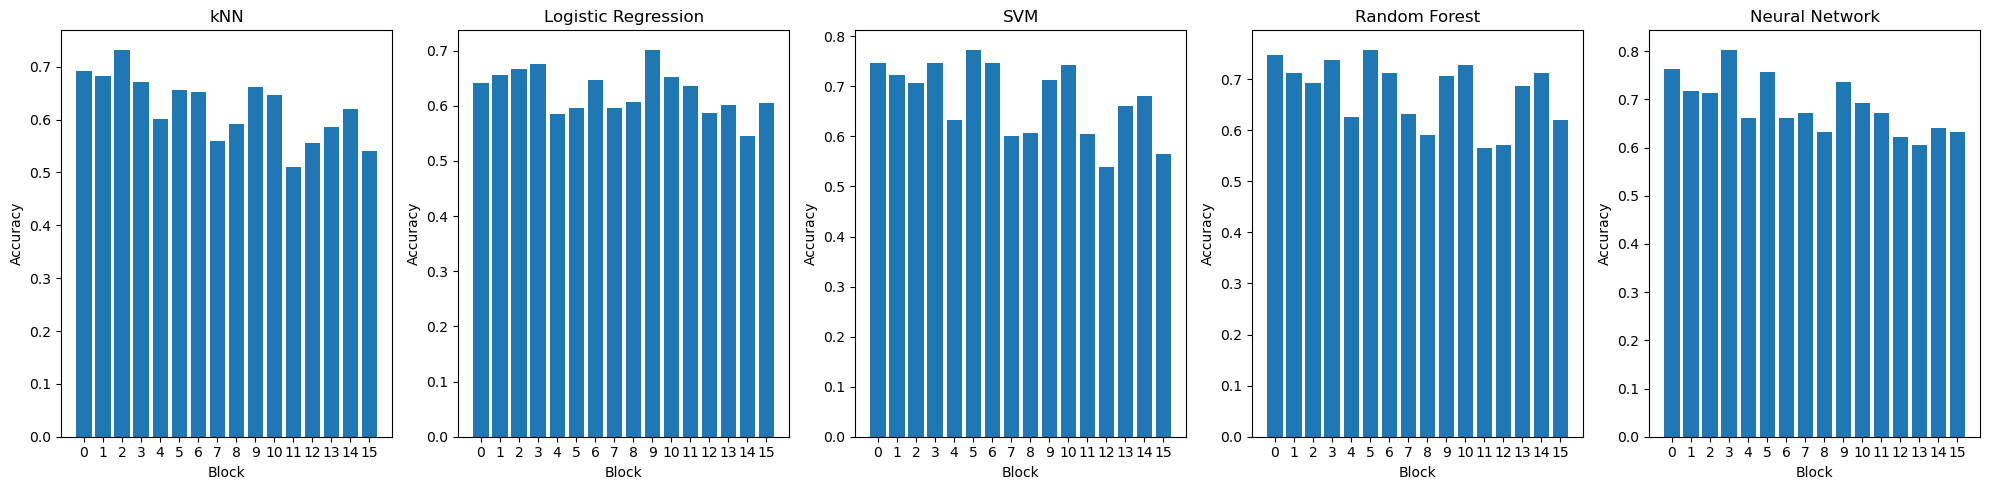

In [19]:
# For each classifier plot the accuracy for each block using a barplot
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
axes = axes.ravel()

for i, (clf, accs) in enumerate(cv_block_accuracy_per_classifier.items()):
    ax = axes[i]
    ax.bar(selected_blocks, accs)
    ax.set_title(clf)
    ax.set_xlabel("Block")
    ax.set_ylabel("Accuracy")
    ax.xaxis.set_ticks(selected_blocks)

plt.tight_layout()
plt.show()

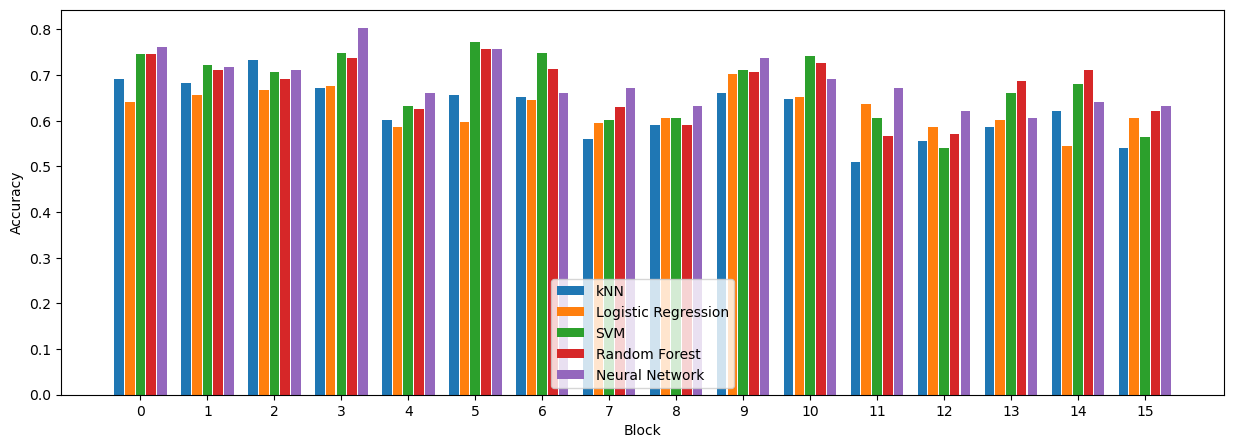

In [20]:
cv_data = {
    "kNN": cv_block_accuracy_per_classifier["kNN"],
    "Logistic Regression": cv_block_accuracy_per_classifier["Logistic Regression"],
    "SVM": cv_block_accuracy_per_classifier["SVM"],
    "Random Forest": cv_block_accuracy_per_classifier["Random Forest"],
    "Neural Network": cv_block_accuracy_per_classifier["Neural Network"],
}

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
bar_plot(ax, cv_data, total_width=0.8, single_width=0.9)
ax.set_xlabel("Block")
ax.set_ylabel("Accuracy")
ax.xaxis.set_ticks(selected_blocks)
plt.show()

## Group Lasso

In [21]:
from group_lasso import GroupLasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

n_total_blocks = 16
n_pixels_per_block = 256
groups = np.repeat(np.arange(n_total_blocks), n_pixels_per_block / n_total_blocks)

# Initialize and fit Group Lasso
group_lasso = GroupLasso(
    groups=groups,
    group_reg=0.1,  # Regularization parameter for groups
    l1_reg=0.01,  # Regularization parameter for L1 penalty
    frobenius_lipschitz=True,
    scale_reg="group_size",
    subsampling_scheme=1,
    n_iter=10000,
    tol=1e-3,
    warm_start=True,
    random_state=42,
    supress_warning=True,
)

blocks = df_blocks.iloc[:, :-2].values
labels = df_blocks["Label"].values

group_lasso.fit(blocks, labels)

# Identify the most important block
coef = group_lasso.coef_
block_importance = np.sum(np.abs(coef.reshape(n_total_blocks, -1)), axis=1)
most_important_block = np.argmax(block_importance)

print(f"Most important block index: {most_important_block}")

Most important block index: 6


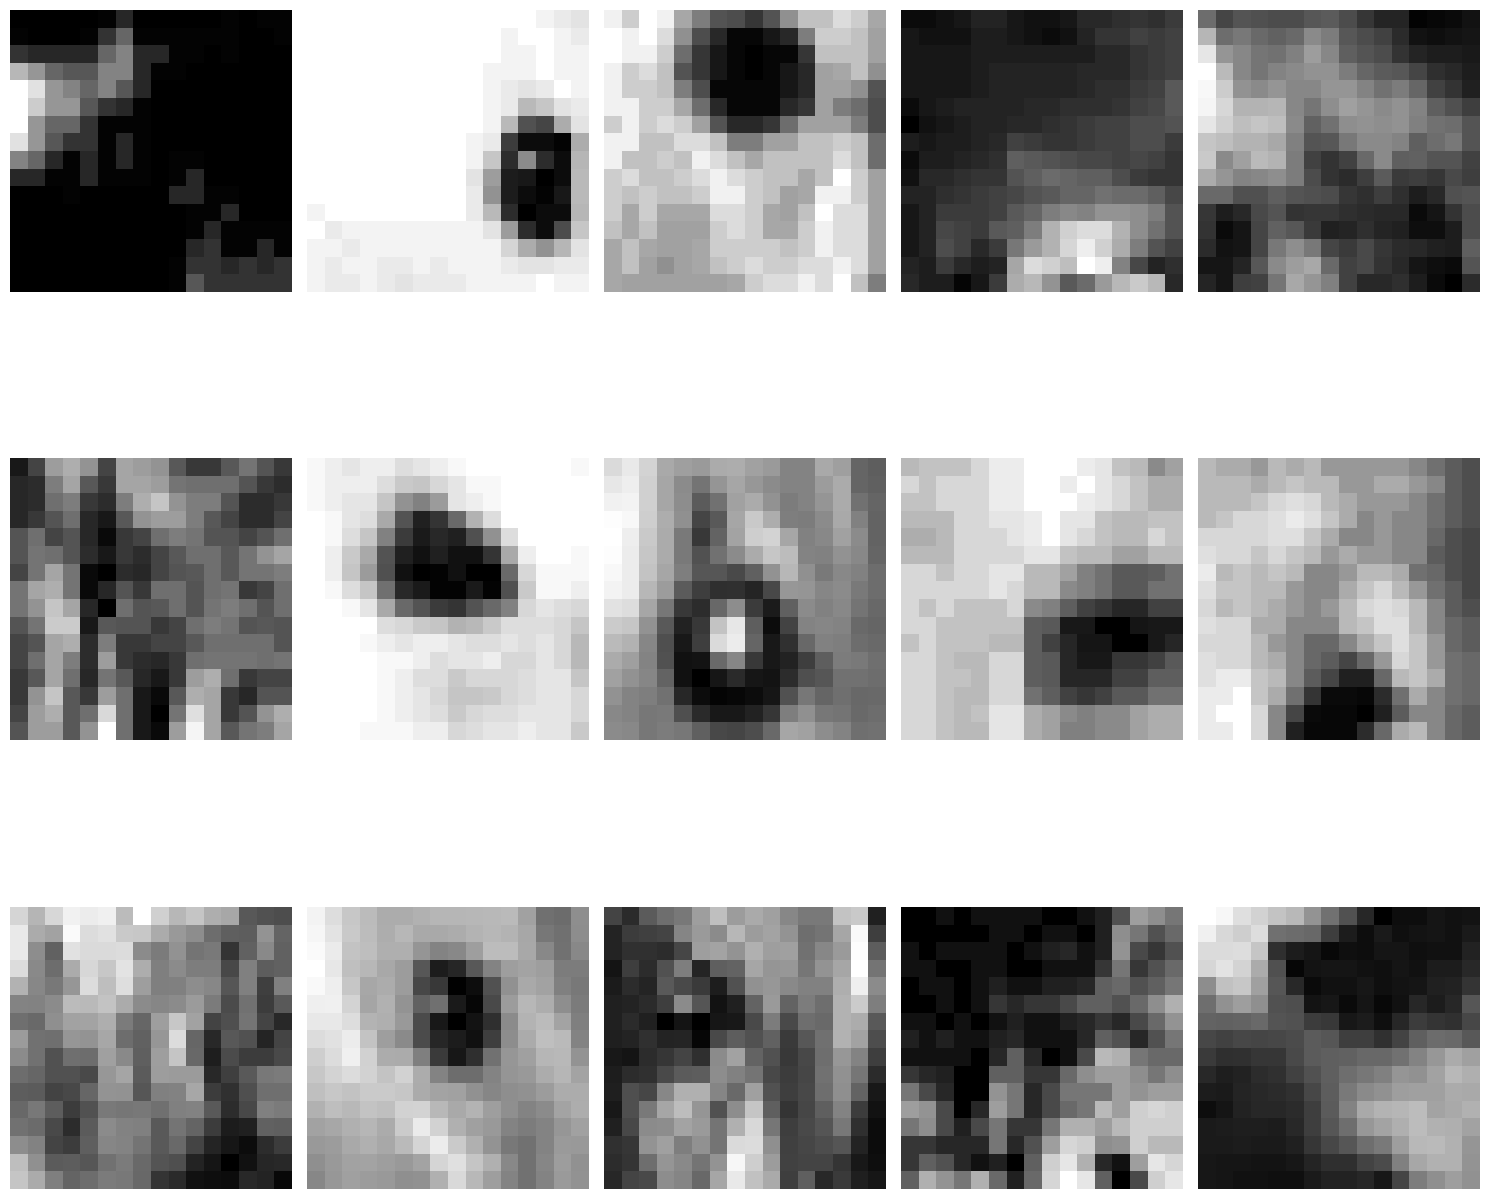

In [22]:
# Get all blocks from the most important block
most_important_block_data = df_blocks[df_blocks["Block"] == most_important_block]
most_important_block_data = most_important_block_data.iloc[:, :-2].values

# Sample random blocks from the most important block
n_samples = 15 
n_plot_rows = 3

sampled_blocks = most_important_block_data[np.random.choice(most_important_block_data.shape[0], n_samples, replace=False)]

fig, axes = plt.subplots(n_plot_rows, n_samples // n_plot_rows, figsize=(15, 15))
axes = axes.ravel()

for i, ax in enumerate(axes):
    plot_image_on_ax(ax, sampled_blocks[i], pixel_size=16)

plt.tight_layout()
plt.show()

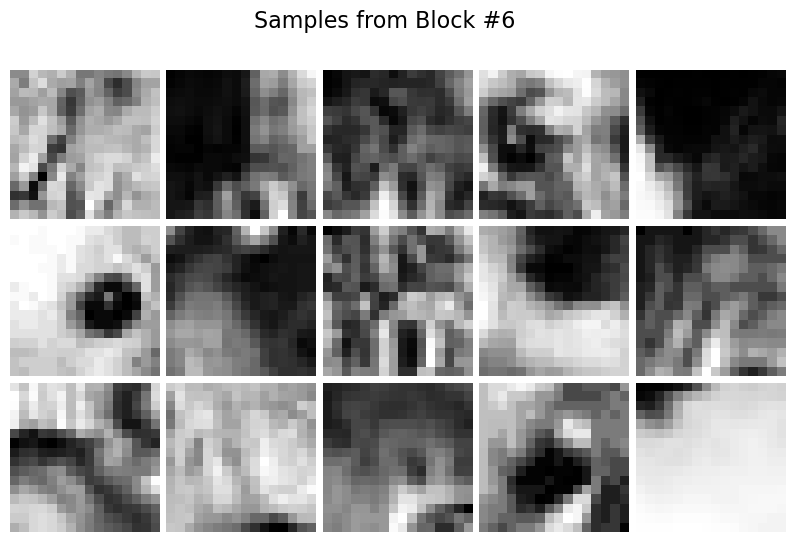

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assume df_blocks is already defined and loaded with the data

def plot_image_on_ax(ax, image, pixel_size):
    ax.imshow(image.reshape(pixel_size, pixel_size), cmap='gray', interpolation='nearest')
    ax.axis('off')

# Get all blocks from the most important block
most_important_block = 6  # Example block number, change accordingly
most_important_block_data = df_blocks[df_blocks["Block"] == most_important_block]
most_important_block_data = most_important_block_data.iloc[:, :-2].values

# Sample random blocks from the most important block
n_samples = 15 
n_plot_rows = 3

sampled_blocks = most_important_block_data[np.random.choice(most_important_block_data.shape[0], n_samples, replace=False)]

fig, axes = plt.subplots(n_plot_rows, n_samples // n_plot_rows, figsize=(10, 6))
axes = axes.ravel()

for i, ax in enumerate(axes):
    plot_image_on_ax(ax, sampled_blocks[i], pixel_size=16)

plt.suptitle('Samples from Block #6', fontsize=16)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()


In [24]:
# Train each classifiers on the most important block
X = most_important_block_data
y = df_blocks[df_blocks["Block"] == most_important_block]["Label"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a classifier
classifiers = {
    "kNN": KNeighborsClassifier(n_neighbors=11),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Neural Network": MLPClassifier(max_iter=1000)
}

for clf_string, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{clf_string} accuracy: {acc}")

kNN accuracy: 0.675
Logistic Regression accuracy: 0.675
SVM accuracy: 0.75
Random Forest accuracy: 0.75
Neural Network accuracy: 0.65
